Use basic Fully connected network to compare the different activation functions on adversarial robustness and accuracy. +-2hours to run with 10 loops


In [52]:
!pip install --quiet foolbox
!pip install --quiet scikit-learn

In [53]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import foolbox as fb
import eagerpy as ep
from sklearn.model_selection import train_test_split
from datetime import datetime


In [54]:
# Constants
dimension = 4 # dimension of dataset
noise = True # add noise to the dataset
dataset_type = 'circle' # 'circle' or 'square'
num_points = 3200 # number of points in the dataset
num_epochs = 1000 # number of epochs before training is stopped
number_of_loops = 10 # number of times that each experiment is repeated
batch_size = 32
max_epsilon = 1.2
number_of_epsilons = int(max_epsilon * 40) # number of different attack values that are tested
epsilons = np.linspace(0.0, max_epsilon, number_of_epsilons) # relative attack values
learning_rate = 0.001 # learning rate for training
weight_decay = 1e-5 # weight decay for training
margin = 0.0013232710934127376 # margin for hinge loss


# Models
model_names = [
    'ReLU', 'Leaky ReLU', 'Softplus',
    'Leaky Softplus', 'Semi-Leaky Softplus','Tanh',
    'Leaky Tanh', 'Sigmoid', 'Leaky Sigmoid'
]

# Corresponding colors for each model
colors = [
    'blue', 'lightblue', 'darkorange', 'orange', 'gold', 'green',
    'lightgreen', 'red', 'pink'
]

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [56]:
# Define activation functions

def LeakyReLU(x,left_slope=0.01,right_slope=1):
  return torch.max(left_slope*x, right_slope*x)

def ReLU(x):
  return LeakyReLU(x,0)

def Softplus(x):
  return torch.log(1+torch.exp(x))

def LeakySoftplus(x):
  return 0.01*x+ torch.log(1+torch.exp(x)) - 0.693147207

def SemiLeakySoftplus(x):
  return torch.where(x < 0, 0.01 * x + torch.log(1 + torch.exp(x)), torch.log(1 + torch.exp(x))) - 0.693147207

def Tanh(x):
  return torch.tanh(x)

def LeakyTanh(x):
  return 0.01*x + Tanh(x)

def Sigmoid(x):
  return 1/(1+torch.exp(-x))

def LeakySigmoid(x):
  return 0.01*x + Sigmoid(x)

In [57]:
# Utils --> from the paper 'Dynamical Systems'

def sumOne(u):
  u = Positive(u)
  u = u/torch.sum(u)
  return Positive(u)

def Positive(X):
    return torch.abs(X)

# From https://github.com/JiJingYu/delta_orthogonal_init_pytorch/blob/master/demo.py
def genOrthgonal(dim):
    a = torch.zeros((dim, dim)).normal_(0, 1)
    q, r = torch.linalg.qr(a)
    d = torch.diag(r, 0).sign()
    diag_size = d.size(0)
    d_exp = d.view(1, diag_size).expand(diag_size, diag_size)
    q.mul_(d_exp)
    return q

def makeDeltaOrthogonal(weights, gain):
    rows = weights.size(0)
    cols = weights.size(1)
    if rows > cols:
        print("In_filters should not be greater than out_filters.")
    weights.data.fill_(0)
    dim = max(rows, cols)
    q = genOrthgonal(dim)
    mid1 = weights.size(2) // 2
    mid2 = weights.size(3) // 2
    weights[:, :, mid1, mid2] = q[:weights.size(0), :weights.size(1)]
    weights.mul_(gain)

#Convolutional layers
def deconv_orth_dist(kernel, padding = 2, stride = 1):
    [o_c, i_c, w, h] = kernel.shape
    output = torch.conv2d(kernel, kernel, padding=padding)
    target = torch.zeros((o_c, o_c, output.shape[-2], output.shape[-1])).to(kernel.device)
    ct = int(np.floor(output.shape[-1]/2))
    target[:,:,ct,ct] = torch.eye(o_c).to(kernel.device)
    return torch.norm( output - target )

def conv_orth_dist(kernel, stride = 1):
    [o_c, i_c, w, h] = kernel.shape
    assert (w == h),"Do not support rectangular kernel"
    assert stride<w,"Please use matrix orthgonality instead"
    new_s = stride*(w-1) + w#np.int(2*(half+np.floor(half/stride))+1)
    temp = torch.eye(new_s*new_s*i_c).reshape((new_s*new_s*i_c, i_c, new_s,new_s)).to(kernel.device)
    out = (F.conv2d(temp, kernel, stride=stride)).reshape((new_s*new_s*i_c, -1))
    Vmat = out[np.floor(new_s**2/2).astype(int)::new_s**2, :]
    temp= np.zeros((i_c, i_c*new_s**2))
    for i in range(temp.shape[0]):temp[i,np.floor(new_s**2/2).astype(int)+new_s**2*i]=1
    return torch.norm( Vmat@torch.t(out) - torch.from_numpy(temp).float().to(kernel.device) )

#Fully connected layers
def orth_dist(mat, stride=None):
    mat = mat.reshape( (mat.shape[0], -1) )
    if mat.shape[0] < mat.shape[1]:
        mat = mat.permute(1,0)
    return torch.norm( torch.t(mat)@mat - torch.eye(mat.shape[1]).to(mat.device))

def power_method(A, A_t, u_init, k=1):
    u = u_init
    for i in range(k):
        v = A(u)
        v /= torch.sqrt(torch.sum(v**2))
        u = A_t(v)
        sigma = torch.sum(u * u)
        u /= torch.sqrt(torch.sum(u**2))
    return sigma, u[0] #so it returns a 3d tensor

def compute_spectral_norm(conv, u_init=None, im_size=(3, 32, 32), k=1):
    if u_init is None:
        with torch.no_grad():
            u_init = torch.randn(1, *im_size).to(conv.weight.device)
    u_init = u_init.to(conv.weight.device)
    with torch.no_grad():
        return power_method(lambda u: torch.nn.functional.conv2d(u, conv.weight, padding=tuple(v//2 for v in conv.weight.shape[2:])),
                lambda v: torch.nn.functional.conv_transpose2d(v, conv.weight, padding=tuple(v//2 for v in conv.weight.shape[2:])),
                u_init, k)

def conv_block(in_channels, out_channels, pool=False):
    convo = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1,bias=False)
    layers = [convo]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [58]:
class multiClassHingeLoss(nn.Module): # From paper Dynamical Systems
    def __init__(self, p=1, margin=margin, device='cpu', size_average=True):
        super(multiClassHingeLoss, self).__init__()
        self.margin=margin
        self.size_average=size_average
        self.device = device

    def forward(self, output, y):
        output_y=output[torch.arange(0,y.size()[0]).long().to(self.device),y.data.to(self.device)].view(-1,1) #it is a (Batch Size x 1) tensor, having entries that are x[y]
        loss=output-output_y+self.margin #this has self.margin in position y and the difference between the entry of x and x[y] in the other positions
        #remove i=y items
        loss[torch.arange(0,y.size()[0]).long().to(self.device),y.data.to(self.device)]=0 #sets to 0 the entry in position y, instead of having self.margin
        #max(0,_)
        loss[loss<0]=0 #sets to 0 the entries of loss where we have negative numbers, i.e. those meeting the margin (there is a higher difference than the margin between x[y] and x[i])
        #sum up
        loss=torch.sum(loss)
        if(self.size_average):
            loss/=output.size()[0]
        return loss

In [59]:
# Define the models
if dataset_type == 'circle':
  num_outputs = 3
elif dataset_type == 'square':
  num_outputs = 4
else:
  raise ValueError("Invalid dataset type. Choose either 'circle' or 'square' at the top of the file.")

class SoftplusModel(nn.Module):
    def __init__(self):
        super(SoftplusModel, self).__init__()
        self.fc1 = nn.Linear(dimension, 31)
        self.fc2 = nn.Linear(31, 3)
        self.fc3 = nn.Linear(3, 8)
        self.fc4 = nn.Linear(8, num_outputs)
        self.name = 'Softplus'

    def forward(self, x):
        x = Softplus(self.fc1(x))
        x = Softplus(self.fc2(x))
        x = Softplus(self.fc3(x))
        x = self.fc4(x)
        return x

class LeakySoftplusModel(nn.Module):
    def __init__(self):
        super(LeakySoftplusModel, self).__init__()
        self.fc1 = nn.Linear(dimension, 31)
        self.fc2 = nn.Linear(31, 3)
        self.fc3 = nn.Linear(3, 8)
        self.fc4 = nn.Linear(8, num_outputs)
        self.name = 'Leaky Softplus'

    def forward(self, x):
        x = LeakySoftplus(self.fc1(x))
        x = LeakySoftplus(self.fc2(x))
        x = LeakySoftplus(self.fc3(x))
        x = self.fc4(x)
        return x

class SemiLeakySoftplusModel(nn.Module):
    def __init__(self):
        super(SemiLeakySoftplusModel, self).__init__()
        self.fc1 = nn.Linear(dimension, 31)
        self.fc2 = nn.Linear(31, 3)
        self.fc3 = nn.Linear(3, 8)
        self.fc4 = nn.Linear(8, num_outputs)
        self.name = 'Semi-Leaky Softplus'

    def forward(self, x):
        x = SemiLeakySoftplus(self.fc1(x))
        x = SemiLeakySoftplus(self.fc2(x))
        x = SemiLeakySoftplus(self.fc3(x))
        x = self.fc4(x)
        return x

class TanhModel(nn.Module):
    def __init__(self):
        super(TanhModel, self).__init__()
        self.fc1 = nn.Linear(dimension, 31)
        self.fc2 = nn.Linear(31, 3)
        self.fc3 = nn.Linear(3, 8)
        self.fc4 = nn.Linear(8, num_outputs)
        self.name = 'Tanh'

    def forward(self, x):
        x = Tanh(self.fc1(x))
        x = Tanh(self.fc2(x))
        x = Tanh(self.fc3(x))
        x = self.fc4(x)
        return x

class LeakyTanhModel(nn.Module):
    def __init__(self):
        super(LeakyTanhModel, self).__init__()
        self.fc1 = nn.Linear(dimension, 31)
        self.fc2 = nn.Linear(31, 3)
        self.fc3 = nn.Linear(3, 8)
        self.fc4 = nn.Linear(8, num_outputs)
        self.name = 'Leaky Tanh'

    def forward(self, x):
        x = LeakyTanh(self.fc1(x))
        x = LeakyTanh(self.fc2(x))
        x = LeakyTanh(self.fc3(x))
        x = self.fc4(x)
        return x


class SigmoidModel(nn.Module):
    def __init__(self):
        super(SigmoidModel, self).__init__()
        self.fc1 = nn.Linear(dimension, 31)
        self.fc2 = nn.Linear(31, 3)
        self.fc3 = nn.Linear(3, 8)
        self.fc4 = nn.Linear(8, num_outputs)
        self.name = 'Sigmoid'

    def forward(self, x):
        x = Sigmoid(self.fc1(x))
        x = Sigmoid(self.fc2(x))
        x = Sigmoid(self.fc3(x))
        x = self.fc4(x)
        return x

class LeakySigmoidModel(nn.Module):
    def __init__(self):
        super(LeakySigmoidModel, self).__init__()
        self.fc1 = nn.Linear(dimension, 31)
        self.fc2 = nn.Linear(31, 3)
        self.fc3 = nn.Linear(3, 8)
        self.fc4 = nn.Linear(8, num_outputs)
        self.name = 'Leaky Sigmoid'

    def forward(self, x):
        x = LeakySigmoid(self.fc1(x))
        x = LeakySigmoid(self.fc2(x))
        x = LeakySigmoid(self.fc3(x))
        x = self.fc4(x)
        return x


class ReluModel(nn.Module):
    def __init__(self):
        super(ReluModel, self).__init__()
        self.fc1 = nn.Linear(dimension, 31)
        self.fc2 = nn.Linear(31, 3)
        self.fc3 = nn.Linear(3, 8)
        self.fc4 = nn.Linear(8, num_outputs)
        self.name = 'ReLU'

    def forward(self, x):
        x = ReLU(self.fc1(x))
        x = ReLU(self.fc2(x))
        x = ReLU(self.fc3(x))
        x = self.fc4(x)
        return x

class LeakyReluModel(nn.Module):
    def __init__(self):
        super(LeakyReluModel, self).__init__()
        self.fc1 = nn.Linear(dimension, 31)
        self.fc2 = nn.Linear(31, 3)
        self.fc3 = nn.Linear(3, 8)
        self.fc4 = nn.Linear(8, num_outputs)
        self.name = 'Leaky ReLU'

    def forward(self, x):
        x = LeakyReLU(self.fc1(x))
        x = LeakyReLU(self.fc2(x))
        x = LeakyReLU(self.fc3(x))
        x = self.fc4(x)
        return x

In [60]:
# Functions used to generate datasets

def GenerateCircleDataset(noise=False, num_points=num_points):
  # Generate random points
  points = np.random.randn(num_points, dimension)

  # Calculate distances to the origin
  distances = np.linalg.norm(points, axis=1)

  # Generate labels: 0 if distance < 2/3, 1 if 2/3 < distance < 4/3, 2 if distance > 4/3
  labels = np.zeros_like(distances)
  labels[distances > 2/3] = 1
  labels[distances > 4/3] = 2

  # Convert numpy arrays to PyTorch tensors
  labels_tensor = torch.tensor(labels, dtype=torch.long)
  if noise:
    noise = 0.1*np.random.randn(num_points, dimension)
    noisy_points = points + noise
    points_tensor = torch.tensor(noisy_points, dtype=torch.float32)
  else:
    points_tensor = torch.tensor(points, dtype=torch.float32)

  return points_tensor, labels_tensor

def GenerateSquareDataset(noise=False, num_points=num_points):
    # Generate random points uniformly between -1 and 1
    points = np.random.uniform(low=-1.0, high=1.0, size=(num_points, dimension))

    # Initialize labels
    labels = np.zeros(num_points)

    # Assign labels based on quadrant
    for i, point in enumerate(points):
        if point[0] >= 0 and point[1] >= 0:
            labels[i] = 0  # Quadrant 1
        elif point[0] < 0 and point[1] >= 0:
            labels[i] = 1  # Quadrant 2
        elif point[0] < 0 and point[1] < 0:
            labels[i] = 2  # Quadrant 3
        else:
            labels[i] = 3  # Quadrant 4

    # Convert numpy arrays to PyTorch tensors
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    if noise:
        # Add noise to the points
        noise = 0.1 * np.random.randn(num_points, dimension)
        noisy_points = points + noise
        points_tensor = torch.tensor(noisy_points, dtype=torch.float32)
    else:
        points_tensor = torch.tensor(points, dtype=torch.float32)

    return points_tensor, labels_tensor

In [61]:
# Functions used to train and attack the models

def TrainAndAttack(model, num_epochs, batch_size, number_of_loops, number_of_epsilons, points_tensor, labels_tensor, accuracy0, robust_accuracy0, patience=6):
  # criterion = nn.CrossEntropyLoss()
  criterion = multiClassHingeLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # Split the data into training and validation sets
  train_points, val_points, train_labels, val_labels = train_test_split(points_tensor, labels_tensor, test_size=0.2)

  best_val_loss = float('inf')
  epochs_without_improvement = 0

  for epoch in range(num_epochs):
      model.train()
      for i in range(0, len(train_points), batch_size):
          inputs = train_points[i:i+batch_size]
          targets = train_labels[i:i+batch_size]

          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, targets)

          if torch.isnan(loss):
            print("NaN loss detected, stopping training.")
            return epoch, -1

          loss.backward()
          optimizer.step()

      # Validation step
      model.eval()
      val_loss = 0.0
      with torch.no_grad():
          for i in range(0, len(val_points), batch_size):
              inputs = val_points[i:i+batch_size]
              targets = val_labels[i:i+batch_size]
              outputs = model(inputs)
              loss = criterion(outputs, targets)
              if torch.isnan(loss):
                print("NaN loss detected, stopping training.")
                return epoch, -1
              val_loss += loss.item()

      val_loss /= len(val_points) // batch_size
      print(f'Time: {datetime.now().strftime("%H:%M:%S")}, Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Val Loss: {val_loss}, Model: {model.name}, Loop: {loop+1} / {number_of_loops}, Epochs without improvement:{epochs_without_improvement}')

      # Check for early stopping
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          epochs_without_improvement = 0
      else:
          epochs_without_improvement += 1
          if epochs_without_improvement >= patience:
              print(f'Early stopping triggered after {epoch+1} epochs')
              break

  with torch.no_grad():
      outputs = model(points_tensor)
      _, predicted = torch.max(outputs, 1)
      accuracy = (predicted == labels_tensor).sum().item() / num_points

  accuracy0[loop] = accuracy
  print(f'Accuracy: {accuracy}, Loop: {loop}')

  model.eval()
  fmodel = fb.PyTorchModel(model, bounds=(-30, 30), preprocessing=None)

  # Create the Foolbox attack
  attack = fb.attacks.LinfDeepFoolAttack()

  # Evaluate the adversarial robustness
  num_adversarial = 0
  attack = fb.attacks.LinfDeepFoolAttack()
  raw, clipped, is_adv = attack(fmodel, points_tensor, labels_tensor, epsilons=epsilons)
  robust_accuracy0[loop] = torch.mean((1-1.*is_adv),axis=1).detach().cpu().numpy()

  return epoch, 0

Time: 13:59:48, Epoch [1/1000], Loss: 0.003072686493396759, Val Loss: 0.0031624303956050426, Model: ReLU, Loop: 1 / 10, Epochs without improvement:0
Time: 13:59:48, Epoch [2/1000], Loss: 0.0012937551364302635, Val Loss: 0.0016874771361472085, Model: ReLU, Loop: 1 / 10, Epochs without improvement:0
Time: 13:59:48, Epoch [3/1000], Loss: 0.0009454631363041699, Val Loss: 0.0009258331308956258, Model: ReLU, Loop: 1 / 10, Epochs without improvement:0
Time: 13:59:49, Epoch [4/1000], Loss: 0.0007487447001039982, Val Loss: 0.0007445976239978336, Model: ReLU, Loop: 1 / 10, Epochs without improvement:0
Time: 13:59:49, Epoch [5/1000], Loss: 0.0007319888682104647, Val Loss: 0.0007364489123574458, Model: ReLU, Loop: 1 / 10, Epochs without improvement:0
Time: 13:59:49, Epoch [6/1000], Loss: 0.0007002254133112729, Val Loss: 0.0007431629812344909, Model: ReLU, Loop: 1 / 10, Epochs without improvement:0
Time: 13:59:50, Epoch [7/1000], Loss: 0.0005744255613535643, Val Loss: 0.0006404048297554254, Model: 

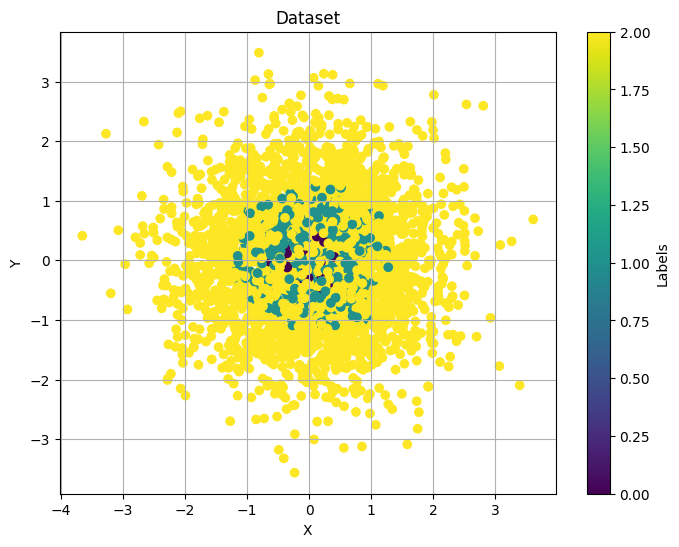

In [62]:
# Initialize arrays
accuracy1 = np.zeros(number_of_loops)
accuracy2 = np.zeros(number_of_loops)
accuracy3 = np.zeros(number_of_loops)
accuracy4 = np.zeros(number_of_loops)
accuracy5 = np.zeros(number_of_loops)
accuracy6 = np.zeros(number_of_loops)
accuracy7 = np.zeros(number_of_loops)
accuracy8 = np.zeros(number_of_loops)
accuracy9 = np.zeros(number_of_loops)

actual_epochs = np.zeros([number_of_loops, 9])
successes = np.zeros([number_of_loops, 9])


robust_accuracy1 = np.zeros((number_of_loops,number_of_epsilons))
robust_accuracy2 = np.zeros((number_of_loops,number_of_epsilons))
robust_accuracy3 = np.zeros((number_of_loops,number_of_epsilons))
robust_accuracy4 = np.zeros((number_of_loops,number_of_epsilons))
robust_accuracy5 = np.zeros((number_of_loops,number_of_epsilons))
robust_accuracy6 = np.zeros((number_of_loops,number_of_epsilons))
robust_accuracy7 = np.zeros((number_of_loops,number_of_epsilons))
robust_accuracy8 = np.zeros((number_of_loops,number_of_epsilons))
robust_accuracy9 = np.zeros((number_of_loops,number_of_epsilons))


# Perform experiments
for loop in range(number_of_loops):
  if dataset_type == 'circle':
    points_tensor, labels_tensor = GenerateCircleDataset(noise=noise)
  elif dataset_type == 'square':
    points_tensor, labels_tensor = GenerateSquareDataset(noise=noise)
  else:
    raise ValueError("Invalid dataset type. Choose either 'circle' or 'square' at the top of the file.")

  # Instantiate the models
  model1 = ReluModel()
  model2 = LeakyReluModel()
  model3 = SoftplusModel()
  model4 = LeakySoftplusModel()
  model5 = SemiLeakySoftplusModel()
  model6 = TanhModel()
  model7 = LeakyTanhModel()
  model8 = SigmoidModel()
  model9 = LeakySigmoidModel()

  # Train and attack the models
  actual_epochs[loop, 0], successes[loop,0] = TrainAndAttack(model1, num_epochs, batch_size, number_of_loops, number_of_epsilons, points_tensor, labels_tensor, accuracy1, robust_accuracy1)
  actual_epochs[loop, 1], successes[loop,1] = TrainAndAttack(model2, num_epochs, batch_size, number_of_loops, number_of_epsilons, points_tensor, labels_tensor, accuracy2, robust_accuracy2)
  actual_epochs[loop, 2], successes[loop,2] = TrainAndAttack(model3, num_epochs, batch_size, number_of_loops, number_of_epsilons, points_tensor, labels_tensor, accuracy3, robust_accuracy3)
  actual_epochs[loop, 3], successes[loop,3] = TrainAndAttack(model4, num_epochs, batch_size, number_of_loops, number_of_epsilons, points_tensor, labels_tensor, accuracy4, robust_accuracy4)
  actual_epochs[loop, 4], successes[loop,4] = TrainAndAttack(model5, num_epochs, batch_size, number_of_loops, number_of_epsilons, points_tensor, labels_tensor, accuracy5, robust_accuracy5)
  actual_epochs[loop, 5], successes[loop,5] = TrainAndAttack(model6, num_epochs, batch_size, number_of_loops, number_of_epsilons, points_tensor, labels_tensor, accuracy6, robust_accuracy6)
  actual_epochs[loop, 6], successes[loop,6] = TrainAndAttack(model7, num_epochs, batch_size, number_of_loops, number_of_epsilons, points_tensor, labels_tensor, accuracy7, robust_accuracy7)
  actual_epochs[loop, 7], successes[loop,7] = TrainAndAttack(model8, num_epochs, batch_size, number_of_loops, number_of_epsilons, points_tensor, labels_tensor, accuracy8, robust_accuracy8)
  actual_epochs[loop, 8], successes[loop,8] = TrainAndAttack(model9, num_epochs, batch_size, number_of_loops, number_of_epsilons, points_tensor, labels_tensor, accuracy9, robust_accuracy9)

  # Visualize the last dataset
  if loop == number_of_loops-1 :
    plt.figure(figsize=(8, 6))
    plt.scatter(points_tensor[:, 0], points_tensor[:, 1], c=labels_tensor, cmap='viridis')
    plt.colorbar(label='Labels')
    plt.title('Dataset')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

In [63]:
# Fix dimensionality
actual_epochs = np.transpose(actual_epochs)
successes = np.transpose(successes)
train_accuracies = [
    accuracy1, accuracy2, accuracy3,
    accuracy4, accuracy5, accuracy6,
    accuracy7, accuracy8, accuracy9
]
train_accuracies = np.array(train_accuracies)
robust_accuracies = [
    robust_accuracy1, robust_accuracy2, robust_accuracy3,
    robust_accuracy4, robust_accuracy5, robust_accuracy6,
    robust_accuracy7, robust_accuracy8, robust_accuracy9
]

# Filter the accuracies to exclude failed runs
marked_train_accuracies = np.where(successes == 0, train_accuracies, np.nan)
average_successful_train_accuracies = np.nanmean(marked_train_accuracies, axis=1)

# Filter the robust accuracies to exclude failed runs
marked_robust_accuracies = robust_accuracies
marked_robust_accuracies = np.array(marked_robust_accuracies)
for j in range(number_of_loops):
  for i in range(9):
    if successes[i,j] == -1:
      marked_robust_accuracies[i,j] = np.nan

average_successful_robust_accuracies = np.zeros_like(average_successful_train_accuracies)
for i in range(9):
  average_successful_robust_accuracies[i] = np.nanmean(marked_robust_accuracies[i,:,:])

Successes, row = model, collumn = loop:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


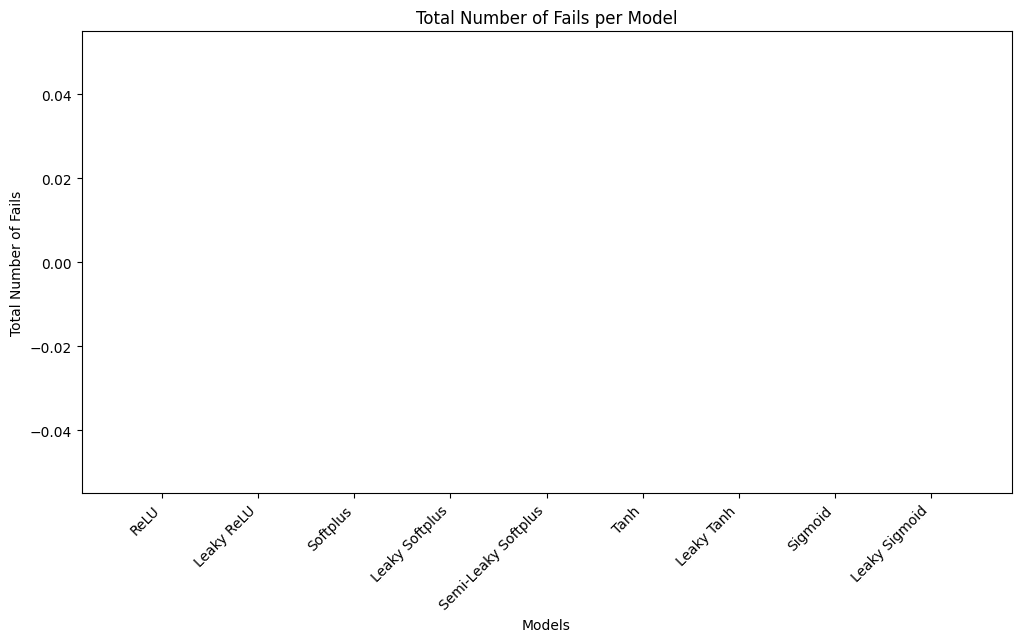

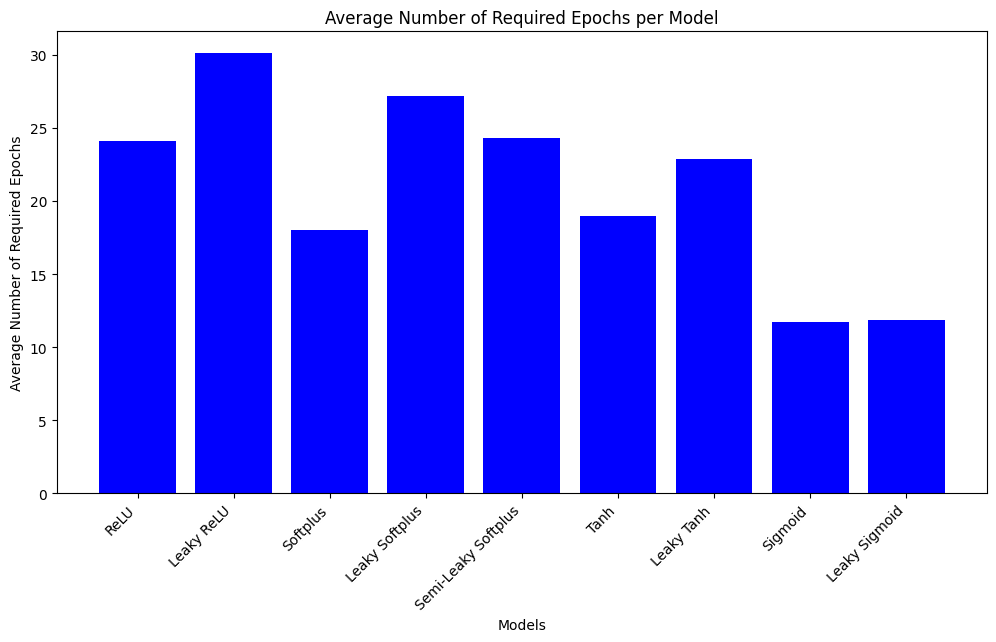

In [64]:
# Calculate the total number of fails per model
fails_per_model = np.sum(successes == -1, axis=1)

# Calculate the average number of required epochs per model (excluding failed ones)
avg_epochs_per_model = np.where(successes != -1, actual_epochs, np.nan)
avg_epochs_per_model = np.nanmean(avg_epochs_per_model, axis=1)

# Plot the total number of fails per model
plt.figure(figsize=(12, 6))
plt.bar(model_names, fails_per_model, color='red')
plt.xlabel('Models')
plt.ylabel('Total Number of Fails')
plt.title('Total Number of Fails per Model')
plt.xticks(rotation=45, ha='right')
plt.show()

# Plot the average number of required epochs per model
plt.figure(figsize=(12, 6))
plt.bar(model_names, avg_epochs_per_model, color='blue')
plt.xlabel('Models')
plt.ylabel('Average Number of Required Epochs')
plt.title('Average Number of Required Epochs per Model')
plt.xticks(rotation=45, ha='right')
plt.show()

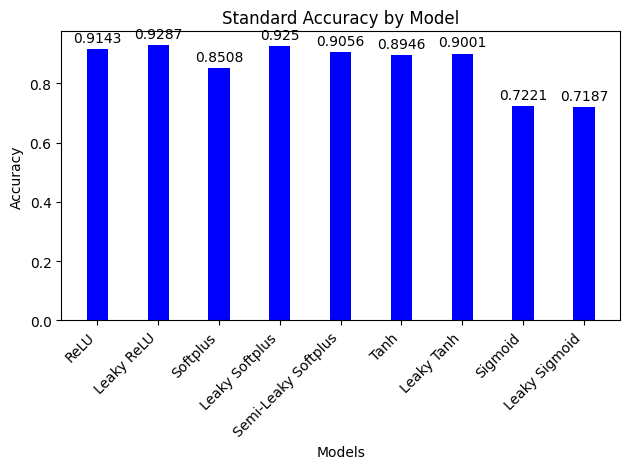

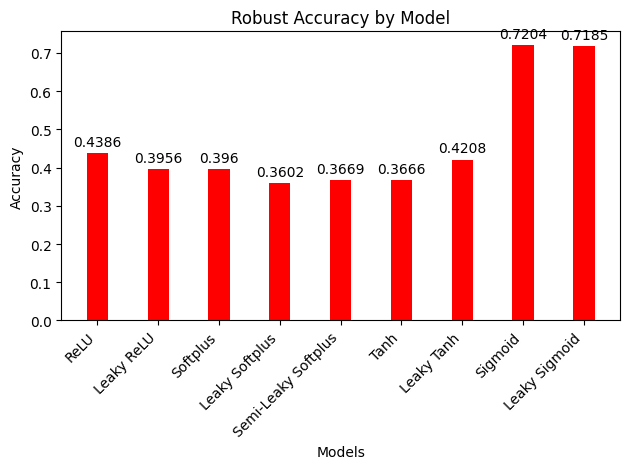

In [65]:
# Plot accuracies
n_models = len(average_successful_train_accuracies)  # Number of models
ind = np.arange(n_models)  # the x locations for the groups
width = 0.35  # the width of the bars
fig1, ax1 = plt.subplots()
train_bars = ax1.bar(ind, average_successful_train_accuracies, width, label='Standard', color='b')
# Add some text for labels, title, and custom x-axis tick labels, etc.
ax1.set_xlabel('Models')
ax1.set_ylabel('Accuracy')
ax1.set_title('Standard Accuracy by Model')
ax1.set_xticks(ind)
ax1.set_xticklabels(model_names, rotation=45, ha="right")
def autolabel(bars, ax):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(train_bars, ax1)
fig1.tight_layout()
# Plot robust accuracies
fig2, ax2 = plt.subplots()
robust_bars = ax2.bar(ind, average_successful_robust_accuracies, width, label='Robust', color='r')
# Add some text for labels, title, and custom x-axis tick labels, etc.
ax2.set_xlabel('Models')
ax2.set_ylabel('Accuracy')
ax2.set_title('Robust Accuracy by Model')
ax2.set_xticks(ind)
ax2.set_xticklabels(model_names, rotation=45, ha="right")
autolabel(robust_bars, ax2)
fig2.tight_layout()
# Show both plots
plt.show()

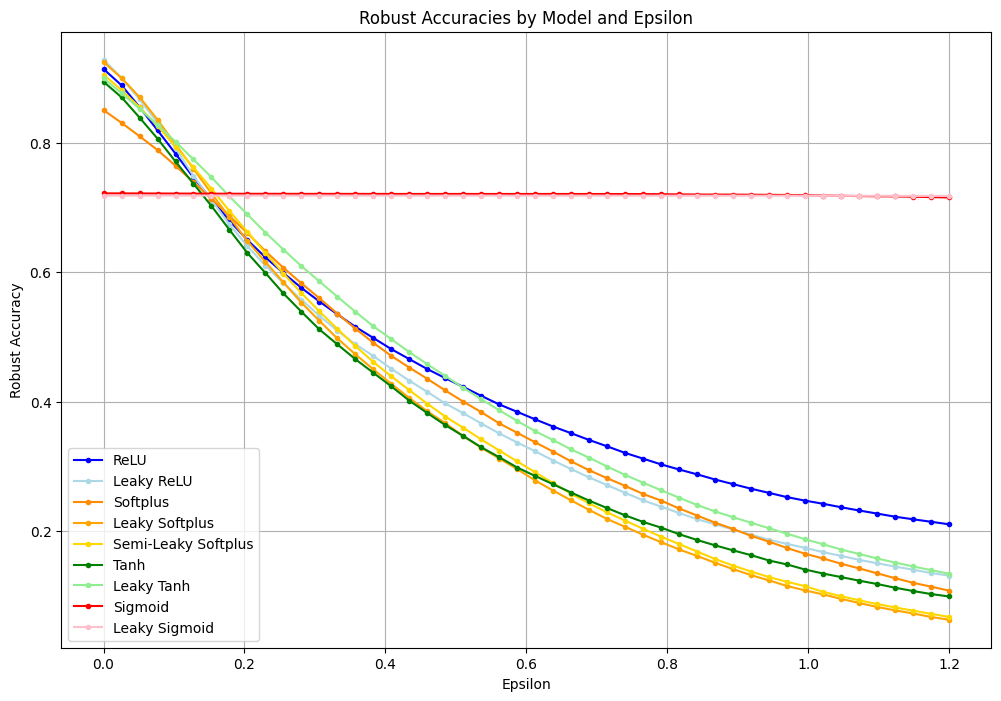

In [66]:
# Filter the robust accuracies to exclude failed runs
average_epsilon_attacks = np.zeros([9, number_of_epsilons])
for i in range(9):
  for j in range(number_of_loops):
    average_epsilon_attacks[i] = np.nanmean(marked_robust_accuracies[i,:,:], axis=0)
plt.figure(figsize=(12, 8))
# Plot each line with corresponding color
for i, array in enumerate(average_epsilon_attacks):
    plt.plot(epsilons, array, marker='.', color=colors[i], label=model_names[i])
# Add labels and legend
plt.xlabel('Epsilon')
plt.ylabel('Robust Accuracy')
plt.title('Robust Accuracies by Model and Epsilon')
plt.legend()
plt.grid(True)
# Show plot
plt.show()

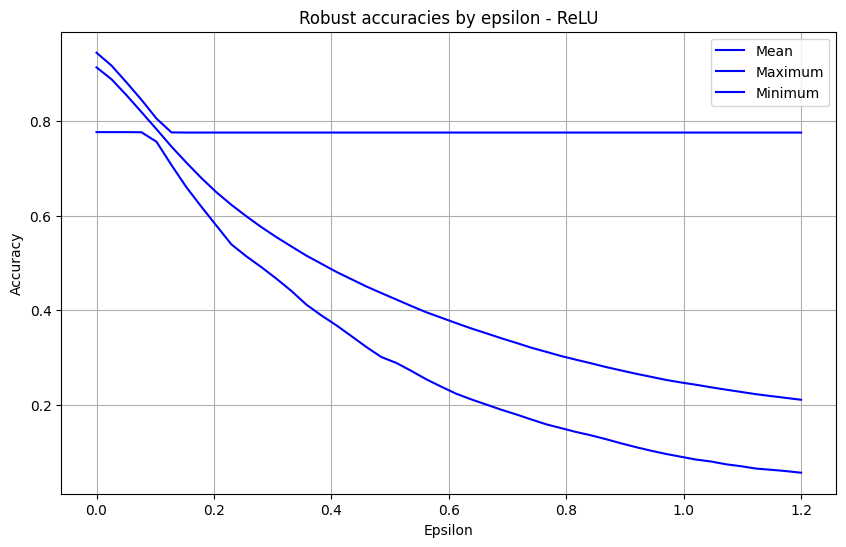

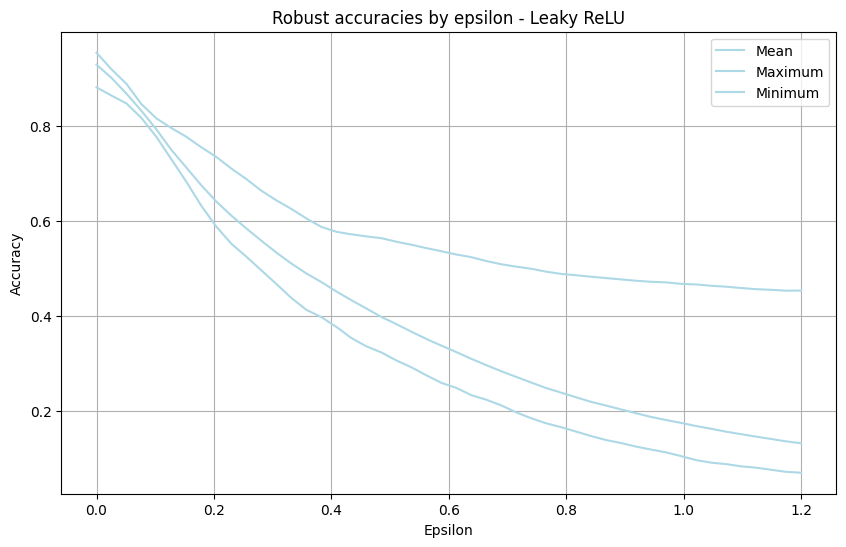

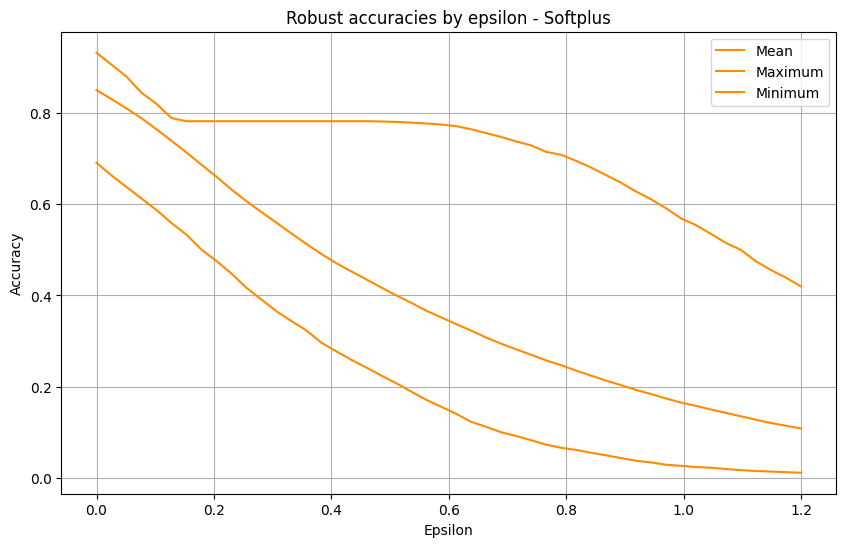

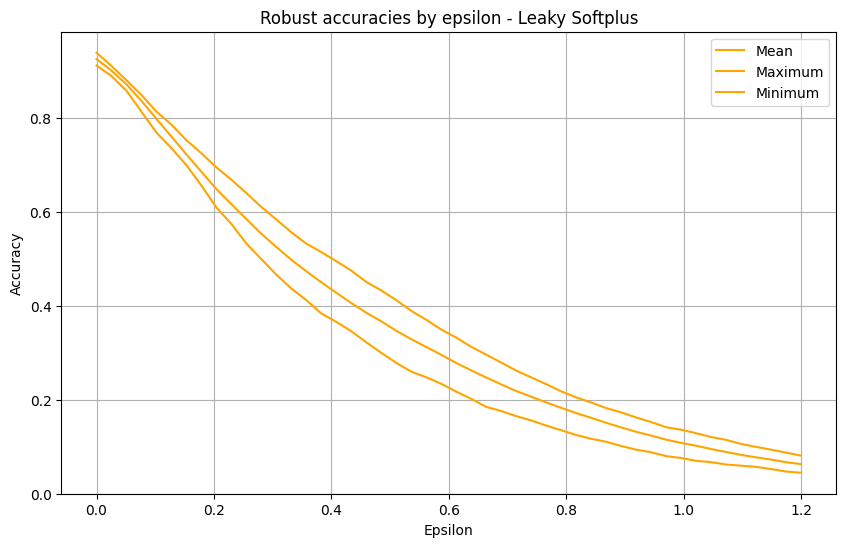

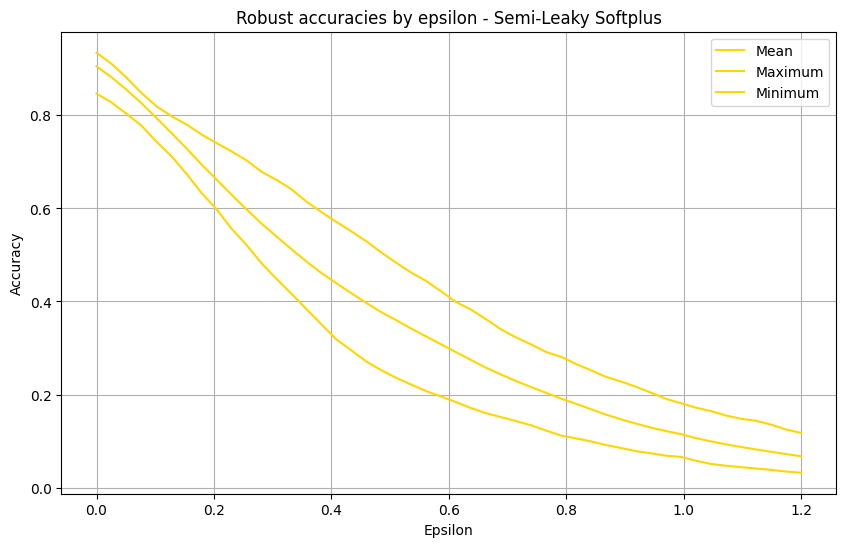

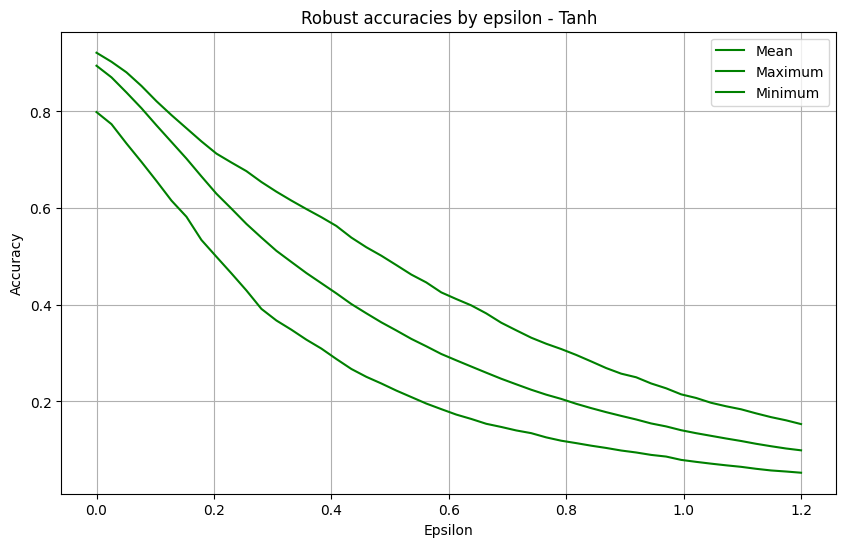

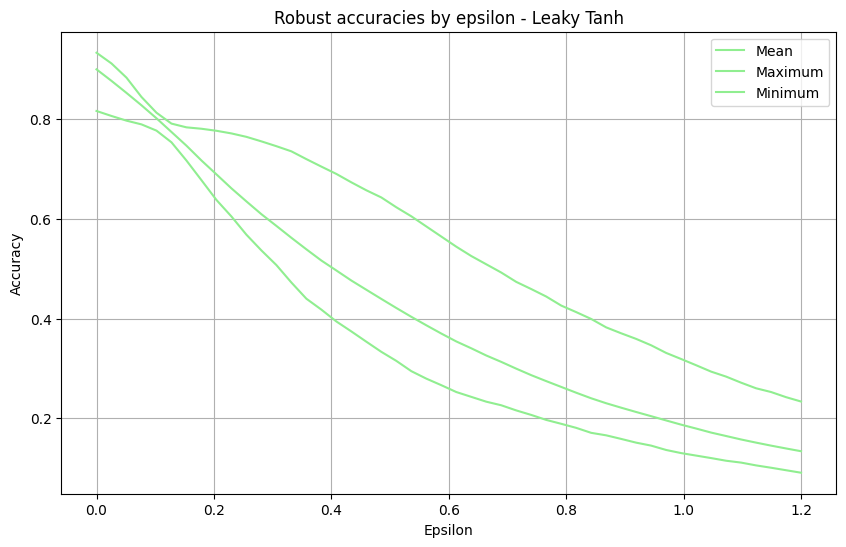

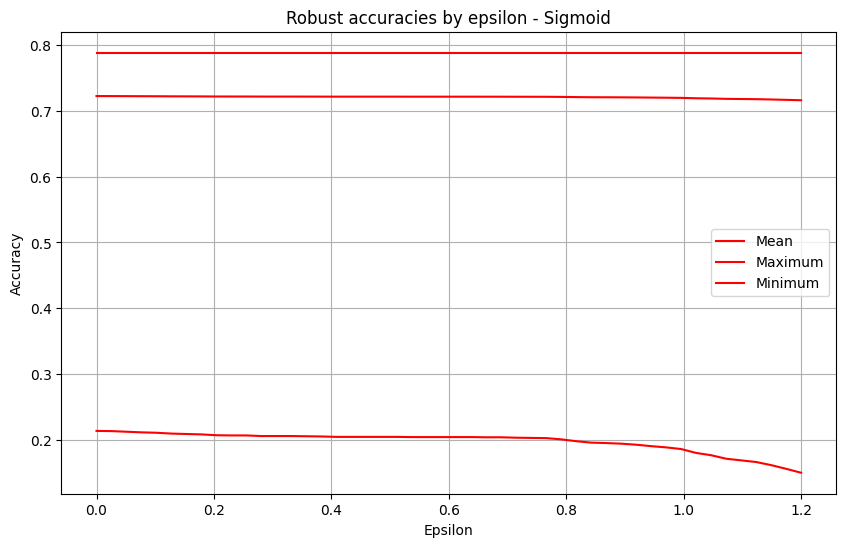

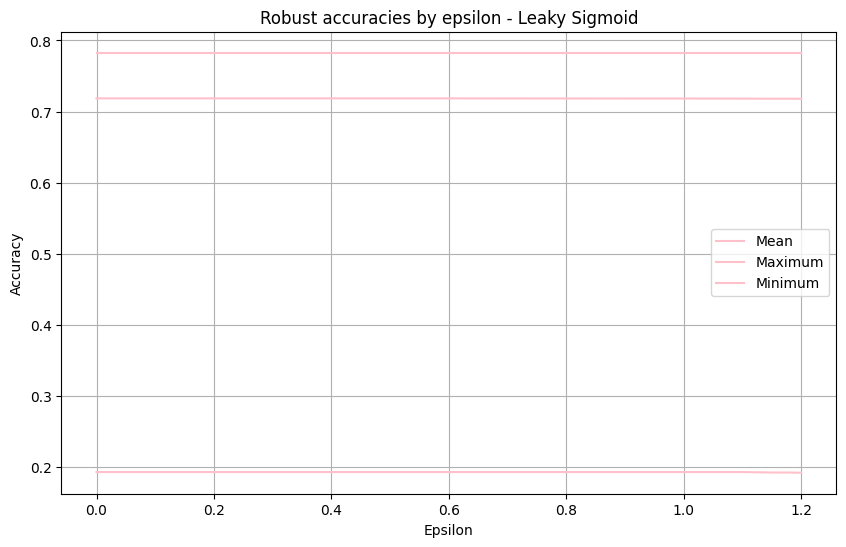

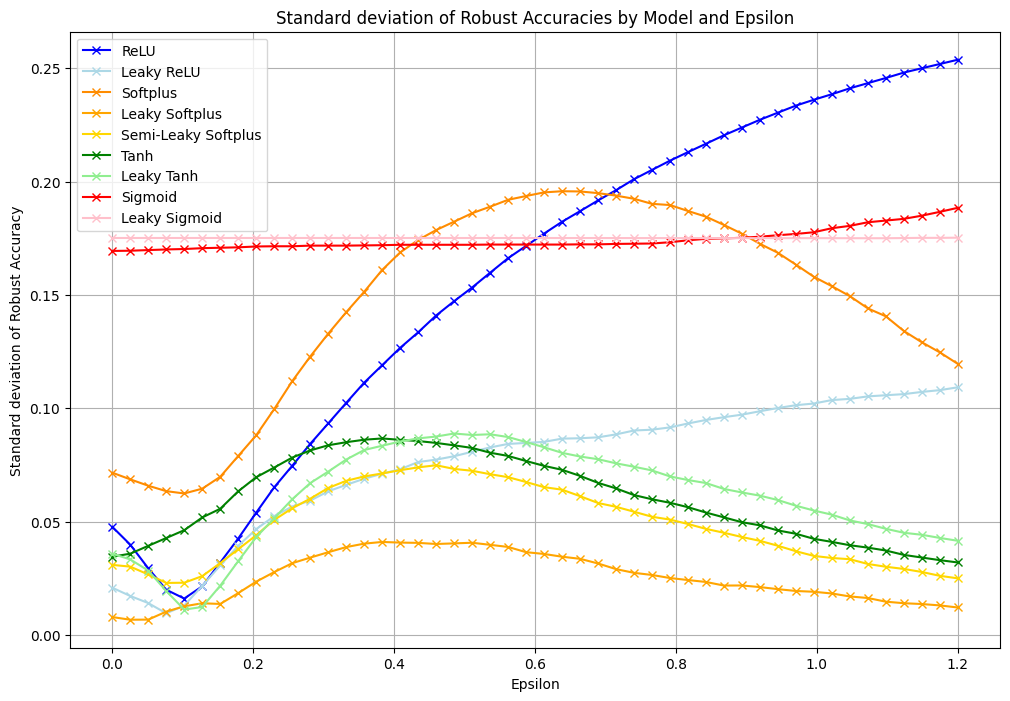

In [67]:
# Robust accuracy per model with minina and maxima + variance
maxima = np.zeros([9, number_of_epsilons])
minima = np.zeros([9, number_of_epsilons])
for i in range(9):
  maxima[i] = np.nanmax(marked_robust_accuracies[i,:,:],axis=0)
  minima[i] = np.nanmin(marked_robust_accuracies[i,:,:],axis=0)
n_models = len(marked_robust_accuracies)
var_accuracies = np.zeros((n_models, len(epsilons)))
# Plot each line with error bars for mean, max, and min accuracies
for i, array in enumerate(average_epsilon_attacks):
    plt.figure(figsize=(10, 6))
    var_accuracies[i] = np.nanstd(marked_robust_accuracies[i], axis=0) # save for other plot
    plt.plot(epsilons, array, label='Mean', color=colors[i])
    plt.plot(epsilons, maxima[i], label='Maximum', color=colors[i])
    plt.plot(epsilons, minima[i], label='Minimum', color=colors[i])
    # Add labels and legend
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy')
    plt.title('Robust accuracies by epsilon - ' + model_names[i])
    plt.legend()
    plt.grid(True)
    plt.show()
# Plot the variation on robust accuracies
plt.figure(figsize=(12, 8))
for i, array in enumerate(var_accuracies):
    plt.plot(epsilons, array, marker='x', label=model_names[i], color=colors[i])
# Add labels and legend
plt.xlabel('Epsilon')
plt.ylabel('Standard deviation of Robust Accuracy')
plt.title('Standard deviation of Robust Accuracies by Model and Epsilon')
plt.legend()
plt.grid(True)
plt.show()

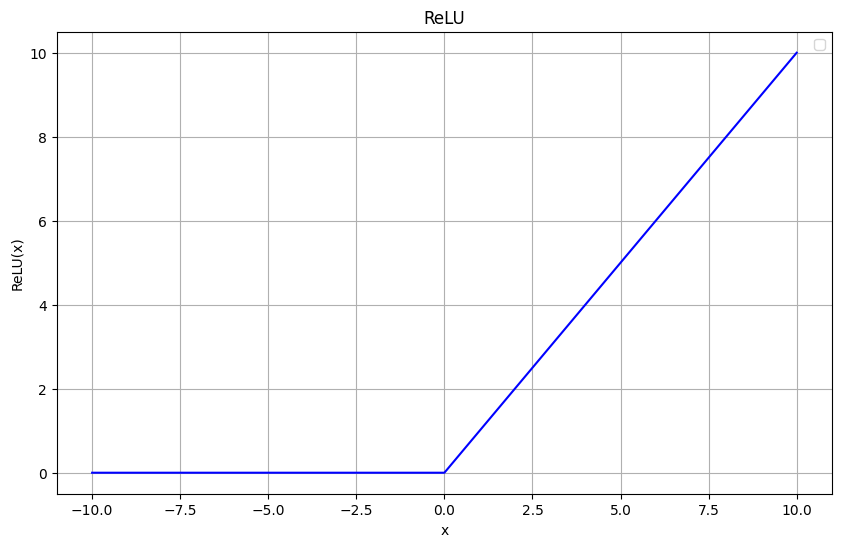

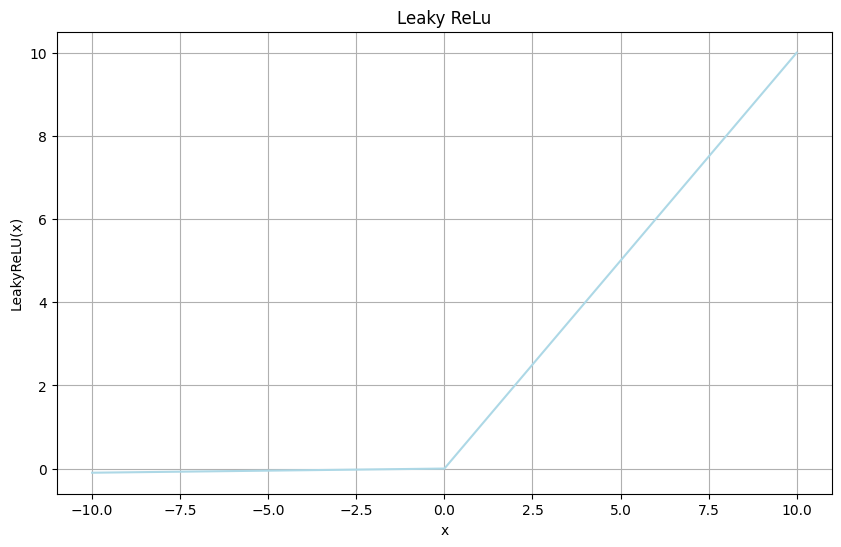

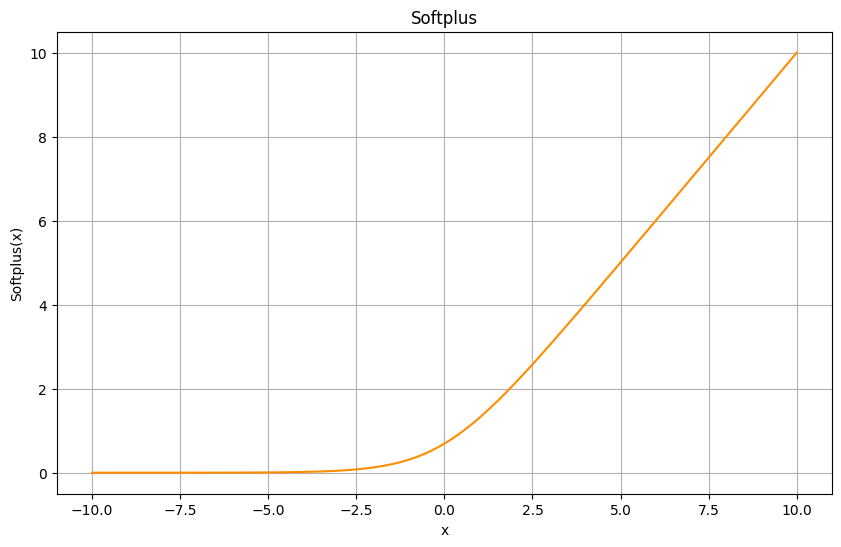

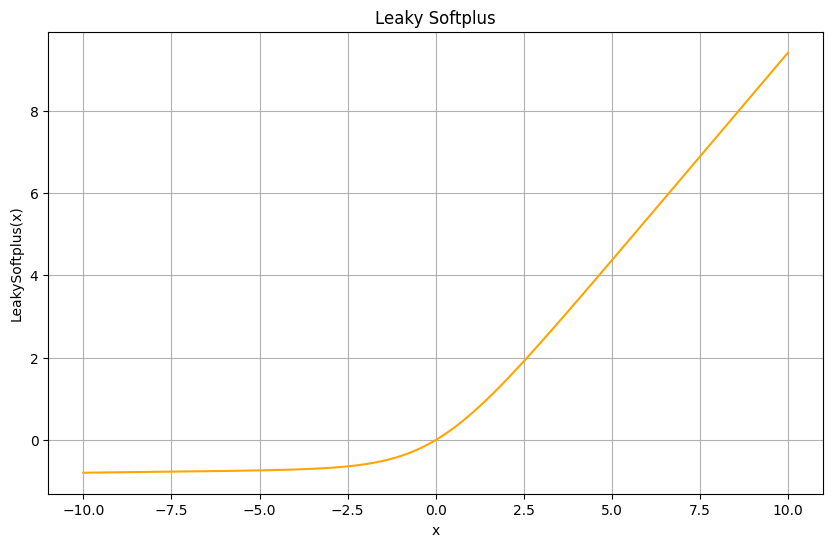

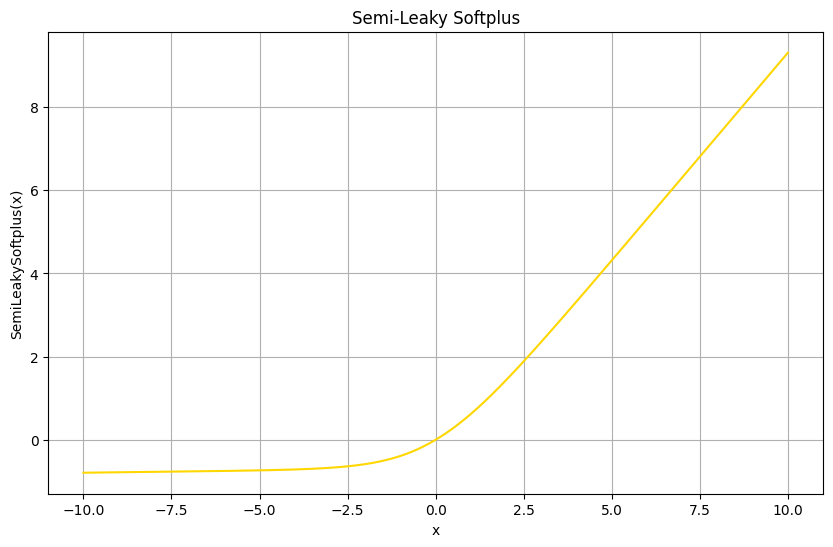

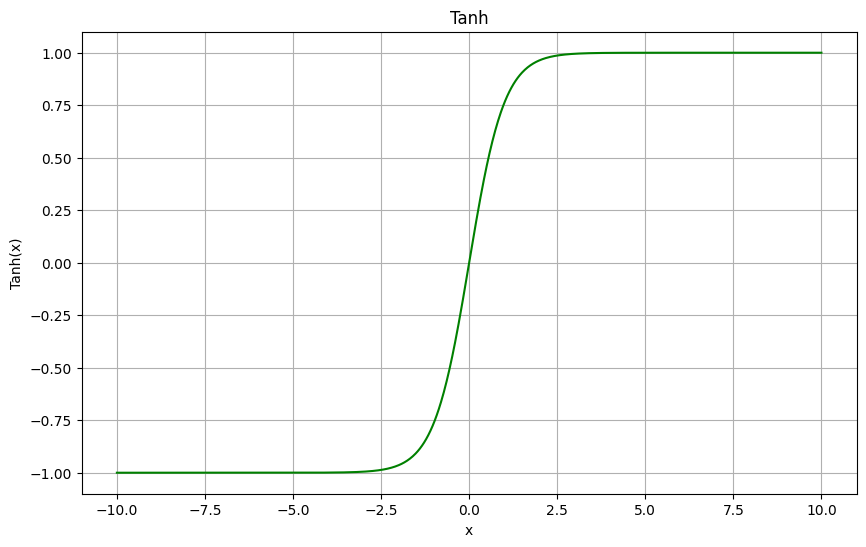

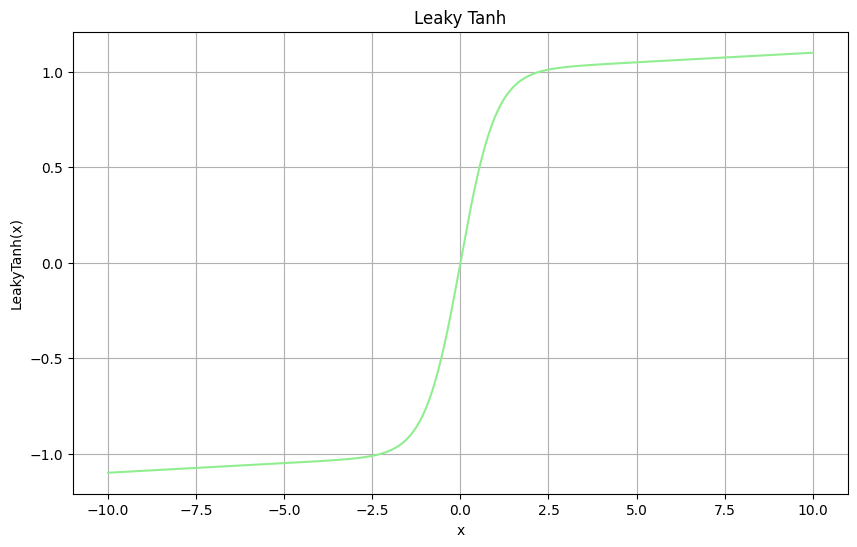

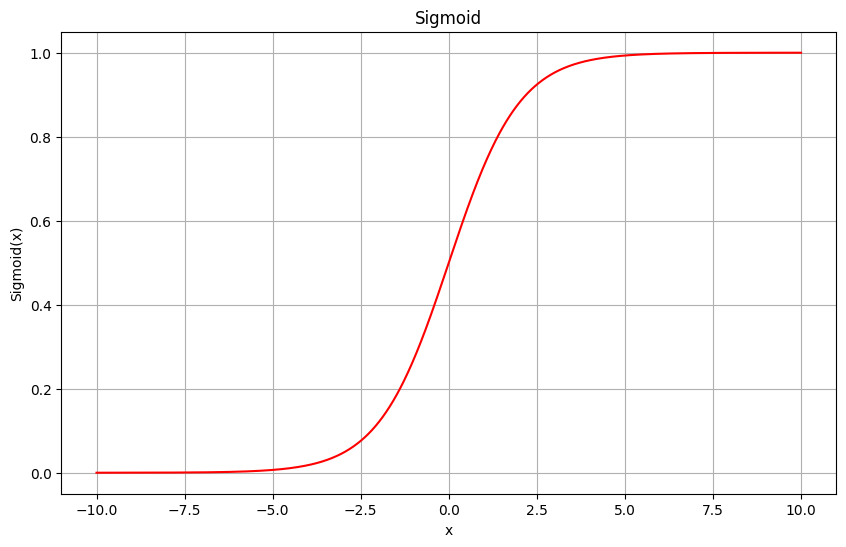

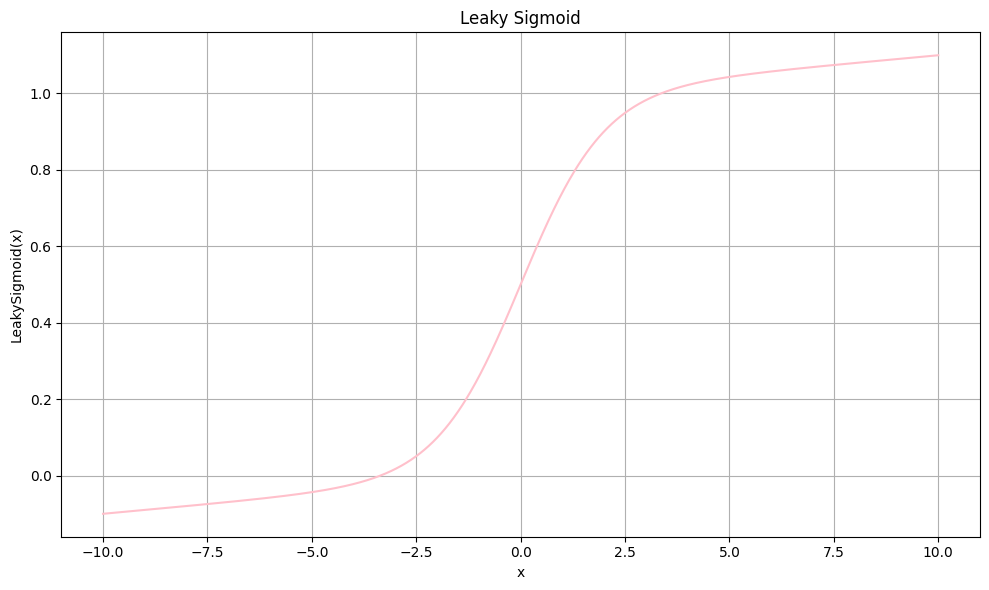

In [68]:
# Plot activation functions

# Generate x values from -5 to 5
x = torch.linspace(-10, 10, 1001)
# Calculate y values for each function
y_relu = ReLU(x)
y_leaky_relu = LeakyReLU(x,0.01,1)
y_softplus = Softplus(x)
y_leaky_softplus = LeakySoftplus(x)
y_semi_leaky_softplus = SemiLeakySoftplus(x)
y_tanh = Tanh(x)
y_leaky_tanh = LeakyTanh(x)
y_sigmoid = Sigmoid(x)
y_leaky_sigmoid = LeakySigmoid(x)

# Plotting
# ReLU
plt.figure(figsize=(10, 6))
plt.plot(x, y_relu, color=colors[0])
plt.title('ReLU')
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.grid(True)
plt.legend()

# Leaky ReLu
plt.figure(figsize=(10, 6))
plt.plot(x, y_leaky_relu, color=colors[1])
plt.title('Leaky ReLu')
plt.xlabel('x')
plt.ylabel('LeakyReLU(x)')
plt.grid(True)

# Softplus
plt.figure(figsize=(10, 6))
plt.plot(x, y_softplus, color=colors[2])
plt.title('Softplus')
plt.xlabel('x')
plt.ylabel('Softplus(x)')
plt.grid(True)

# Leaky Softplus
plt.figure(figsize=(10, 6))
plt.plot(x, y_leaky_softplus, color=colors[3])
plt.title('Leaky Softplus')
plt.xlabel('x')
plt.ylabel('LeakySoftplus(x)')
plt.grid(True)

# Semi-Leaky Softplus
plt.figure(figsize=(10, 6))
plt.plot(x, y_semi_leaky_softplus, color=colors[4])
plt.title('Semi-Leaky Softplus')
plt.xlabel('x')
plt.ylabel('SemiLeakySoftplus(x)')
plt.grid(True)

# Tanh
plt.figure(figsize=(10, 6))
plt.plot(x, y_tanh, color=colors[5])
plt.title('Tanh')
plt.xlabel('x')
plt.ylabel('Tanh(x)')
plt.grid(True)

# Leaky Tanh
plt.figure(figsize=(10, 6))
plt.plot(x, y_leaky_tanh, color=colors[6])
plt.title('Leaky Tanh')
plt.xlabel('x')
plt.ylabel('LeakyTanh(x)')
plt.grid(True)

# Sigmoid
plt.figure(figsize=(10, 6))
plt.plot(x, y_sigmoid, color=colors[7])
plt.title('Sigmoid')
plt.xlabel('x')
plt.ylabel('Sigmoid(x)')
plt.grid(True)

# Leaky Sigmoid
plt.figure(figsize=(10, 6))
plt.plot(x, y_leaky_sigmoid, color=colors[8])
plt.title('Leaky Sigmoid')
plt.xlabel('x')
plt.ylabel('LeakySigmoid(x)')
plt.grid(True)

plt.tight_layout()
plt.show()